In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import scanpy as sc
import scanpy.external as sce
import anndata as ad
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt

from matplotlib import rcParams

In [2]:
style.use('default')
rcParams['figure.figsize'] = 6,6
sc.settings.verbosity = 3  
sc.settings.set_figure_params(dpi=90, facecolor="white")

In [3]:
from IPython.display import HTML, display_html
display_html(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

In [4]:
project_dir = Path.home().joinpath("workspace/analysis/scrnaseq/GSE135779")
project_dir.exists()

True

In [7]:
samples = list(project_dir.joinpath("suppl").glob("GSM*"))

In [6]:
samples[0].stem

'GSM4029923_JB18070'

In [7]:
objs = {_.stem: sc.read_10x_mtx(_, cache=True) for _ in samples if _.is_dir()}

... reading from cache file cache/home-mileschristiansmith-workspace-GSE135779-suppl-GSM4029923_JB18070-matrix.h5ad
... reading from cache file cache/home-mileschristiansmith-workspace-GSE135779-suppl-GSM4029927_JB18074-matrix.h5ad
... reading from cache file cache/home-mileschristiansmith-workspace-GSE135779-suppl-GSM4029945_JB19007-matrix.h5ad
... reading from cache file cache/home-mileschristiansmith-workspace-GSE135779-suppl-GSM4029901_JB17006-matrix.h5ad
... reading from cache file cache/home-mileschristiansmith-workspace-GSE135779-suppl-GSM4029902_JB17007-matrix.h5ad
... reading from cache file cache/home-mileschristiansmith-workspace-GSE135779-suppl-GSM4029947_JB19009-matrix.h5ad
... reading from cache file cache/home-mileschristiansmith-workspace-GSE135779-suppl-GSM4029913_JB17024-matrix.h5ad
... reading from cache file cache/home-mileschristiansmith-workspace-GSE135779-suppl-GSM4029909_JB17020-matrix.h5ad
... reading from cache file cache/home-mileschristiansmith-workspace-GSE

In [9]:
for _ in objs:
    objs[_].obs["source"] = _

In [11]:
adata = ad.concat(objs)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [12]:
adata

AnnData object with n_obs × n_vars = 363083 × 32738
    obs: 'source'

In [13]:
adata.obs_names_make_unique()

In [14]:
md = pd.read_csv(project_dir / "matrix" / "GSE135779_series_matrix.txt.gz", delimiter="\t", skiprows=33, index_col=0, header=None).T.set_index("!Sample_geo_accession")
md.columns = [_.replace("!", "") for _ in md.columns]
md = md.loc[:,["Sample_title", "Sample_source_name_ch1", "Sample_characteristics_ch1"]]
md.columns = pd.Index(["sample_title", "source_name", "age", "age_group", "disease_status",])
md = md.rename_axis("source")

md["age"] = md["age"].str.replace("age: ", "")
md["age_group"] = md["age_group"].str.replace("age group: ", "")
md["disease_status"] = md["disease_status"].str.replace("groups: ", "")

In [21]:
md.head()

sample_title  source_name age age_group disease_status
source                                                               
GSM4029896  cSLE1 [JB17001]  Child SLE 1  17  Children            SLE
GSM4029897  cSLE2 [JB17002]  Child SLE 2  18  Children            SLE
GSM4029898  cSLE3 [JB17003]  Child SLE 3  16  Children            SLE
GSM4029899  cSLE4 [JB17004]  Child SLE 4  17  Children            SLE
GSM4029900  cSLE5 [JB17005]  Child SLE 5  14  Children            SLE

In [22]:
adata.obs["source"] = adata.obs["source"].str.replace("_JB[0-9]+", repl="", regex=True)

In [23]:
index_bak = adata.obs.index

In [24]:
adata.obs = adata.obs.merge(md.reset_index(), on="source", how="outer", ).set_index(index_bak)

In [25]:
adata.obs.head()

source    sample_title            source_name age  \
AAACCTGAGGATATAC-1  GSM4029923  cHD5 [JB18070]  Child Healthy Donor 5  12   
AAACCTGAGTTCCACA-1  GSM4029923  cHD5 [JB18070]  Child Healthy Donor 5  12   
AAACCTGCAAATTGCC-1  GSM4029923  cHD5 [JB18070]  Child Healthy Donor 5  12   
AAACCTGCACTAGTAC-1  GSM4029923  cHD5 [JB18070]  Child Healthy Donor 5  12   
AAACCTGGTCTAAACC-1  GSM4029923  cHD5 [JB18070]  Child Healthy Donor 5  12   

                   age_group disease_status  
AAACCTGAGGATATAC-1  Children             HD  
AAACCTGAGTTCCACA-1  Children             HD  
AAACCTGCAAATTGCC-1  Children             HD  
AAACCTGCACTAGTAC-1  Children             HD  
AAACCTGGTCTAAACC-1  Children             HD

In [26]:
# to import the actual metadata, we need to strip the ' [JB18XXX]' out of the sample_title
adata.obs['sample_title'] = adata.obs['sample_title'].str.replace(pat="\s\[JB\d{5}\]",repl="", regex=True)

In [27]:
clinical_info = pd.read_csv(project_dir / "cSLE_clinical_info.csv")

In [28]:
clinical_info.rename(columns={"Names": "sample_title"}).drop(columns="Age").head()

sample_title Groups Batch Gender Race Ethnicity SLEDAI Physician Notes  \
0         aHD1    aHD    B1      F   AA        NH     ND             NaN   
1         aHD2    aHD    B1      F   EA        NH     ND             NaN   
2         aHD3    aHD    B1      F    H         H     ND             NaN   
3         aHD4    aHD    B2      F    H         H     ND             NaN   
4         aHD5    aHD    B2      F   EA        NH     ND             NaN   

   Collection_year Symptoms  ... DSDNA  C3  C4 ALT AST ALD LDH MSK KIDNEY  \
0             2018      NaN  ...    ND  ND  ND  ND  ND  ND  ND  ND     ND   
1             2018      NaN  ...    ND  ND  ND  ND  ND  ND  ND  ND     ND   
2             2018      NaN  ...    ND  ND  ND  ND  ND  ND  ND  ND     ND   
3             2018      NaN  ...    ND  ND  ND  ND  ND  ND  ND  ND     ND   
4             2018      NaN  ...    ND  ND  ND  ND  ND  ND  ND  ND     ND   

  SERUM  
0    ND  
1    ND  
2    ND  
3    ND  
4    ND  

[5 rows x 57 columns]

In [29]:
adata.obs.head()

source sample_title            source_name age  \
AAACCTGAGGATATAC-1  GSM4029923         cHD5  Child Healthy Donor 5  12   
AAACCTGAGTTCCACA-1  GSM4029923         cHD5  Child Healthy Donor 5  12   
AAACCTGCAAATTGCC-1  GSM4029923         cHD5  Child Healthy Donor 5  12   
AAACCTGCACTAGTAC-1  GSM4029923         cHD5  Child Healthy Donor 5  12   
AAACCTGGTCTAAACC-1  GSM4029923         cHD5  Child Healthy Donor 5  12   

                   age_group disease_status  
AAACCTGAGGATATAC-1  Children             HD  
AAACCTGAGTTCCACA-1  Children             HD  
AAACCTGCAAATTGCC-1  Children             HD  
AAACCTGCACTAGTAC-1  Children             HD  
AAACCTGGTCTAAACC-1  Children             HD

In [30]:
adata.obs = adata.obs.reset_index().merge(clinical_info.rename(columns={"Names": "sample_title"}).drop(columns="Age"), on="sample_title",).set_index("index")

In [31]:
for _ in ["source", "sample_title", "source_name", "age_group", "disease_status", "Groups", "Batch", "Gender", "Race", "Ethnicity"]:
    adata.obs[_] = adata.obs[_].astype("category")

In [32]:
adata.var_names_make_unique()

In [33]:
adata.var = adata.var.rename_axis(index="var")

normalizing counts per cell
    finished (0:00:04)


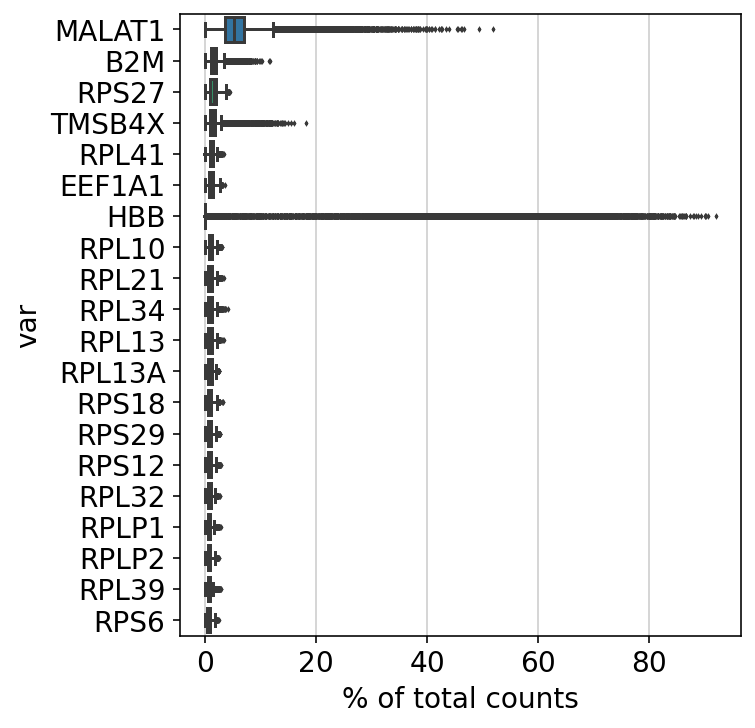

In [34]:
sc.pl.highest_expr_genes(adata, n_top=20,)

Like our data tends to be - a lot of RBCs or RBC contamination.

In [35]:
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 6775 cells that have less than 400 genes expressed
filtered out 8293 genes that are detected in less than 3 cells


In [36]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/home/mileschristiansmith/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'age' as categorical
/home/mileschristiansmith/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'SLEDAI' as categorical
/home/mileschristiansmith/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categor

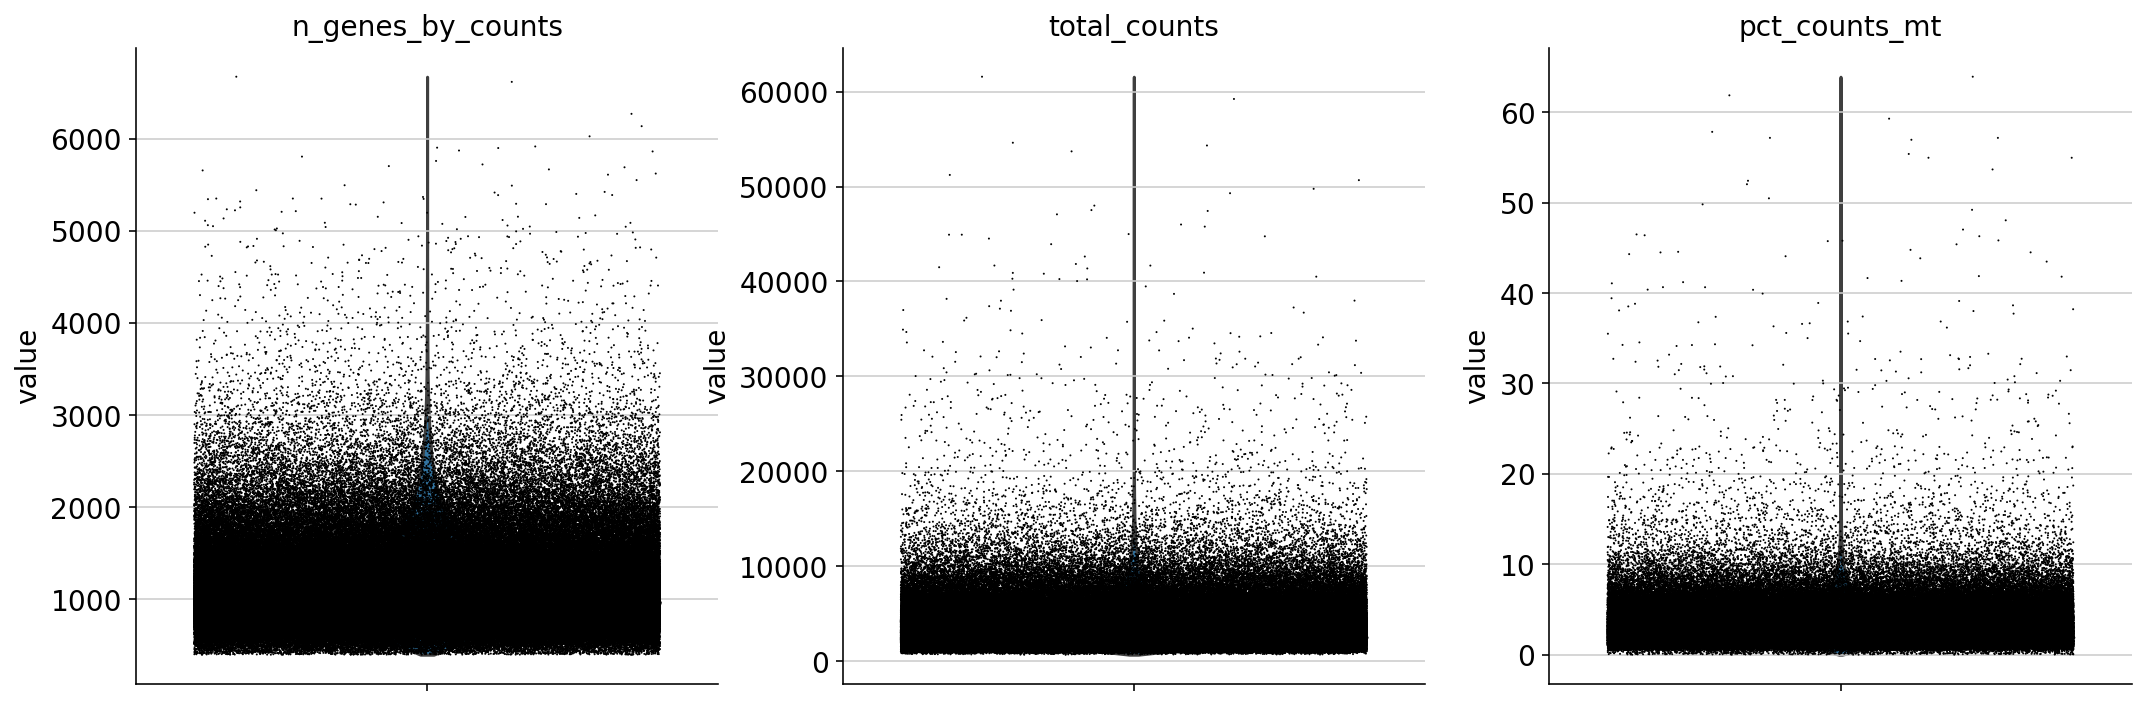

In [37]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

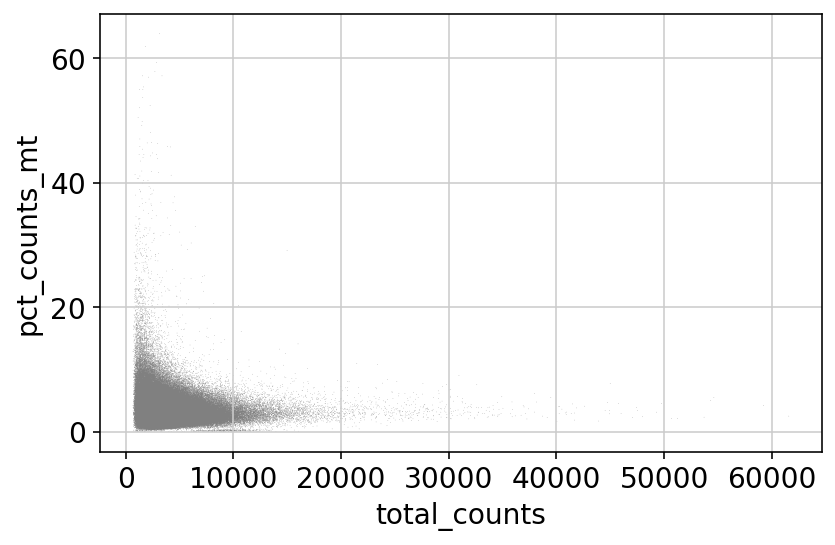

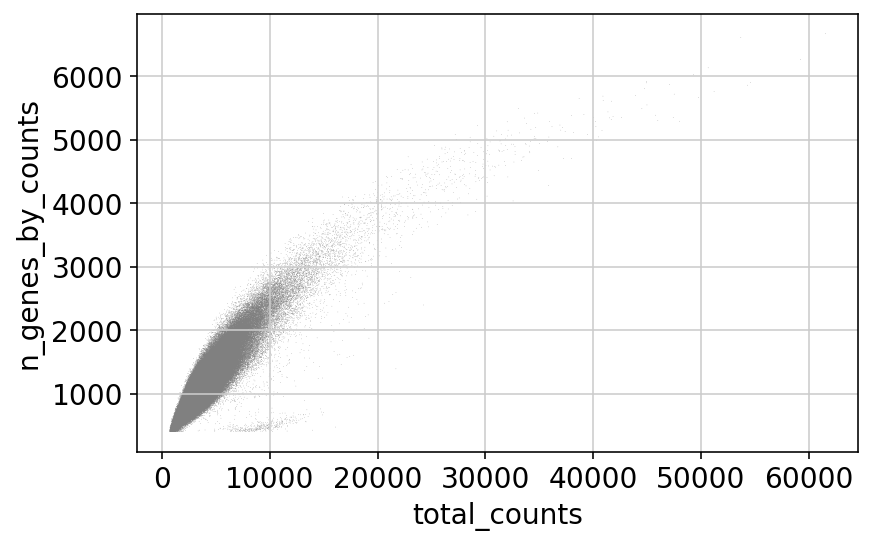

In [38]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [39]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

In [41]:
adata.write(project_dir / "gse135779_prescrublet.h5ad")

In [43]:
sce.pp.scrublet(adata)

Running Scrublet
filtered out 146 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:01)
extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/mileschristiansmith/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:01)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.79
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 3.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.6%
    Scrublet finished (0:31:30)


Trying to set attribute `.obs` of view, copying.


In [49]:
#--- Define threshold to be applyed + define doublet vs. singlet

threshold = 0.18
adata.obs['predicted_doublets_1'] = pd.Categorical(['doublet' if x > threshold else 'singlet' for x in adata.obs["doublet_score"]])
#- number of doublet and singlets 
adata.obs.predicted_doublets_1.value_counts()

singlet    336788
doublet     13920
Name: predicted_doublets_1, dtype: int64

In [50]:
#---- extarct cell predicted as singlets 

cells_of_interest1 = adata.obs.loc[adata.obs["predicted_doublets_1"].isin(["singlet"]), :].index
cells_of_interest1

Index(['AAACCTGAGGATATAC-1', 'AAACCTGAGTTCCACA-1', 'AAACCTGCAAATTGCC-1',
       'AAACCTGCACTAGTAC-1', 'AAACCTGGTCTAAACC-1', 'AAACCTGGTGAGCGAT-1',
       'AAACCTGGTGTGGCTC-1', 'AAACCTGTCAGTTGAC-1', 'AAACCTGTCCAATGGT-1',
       'AAACGGGAGAACAACT-1',
       ...
       'TTTGTCAAGTGTGGCA-1-1', 'TTTGTCACAAGAGGCT-1', 'TTTGTCACAATCTGCA-1',
       'TTTGTCACACCAGTTA-1', 'TTTGTCACACGGTAGA-1-1', 'TTTGTCACAGAAGCAC-1-1',
       'TTTGTCATCCGCGCAA-1', 'TTTGTCATCCTCCTAG-1', 'TTTGTCATCGTCGTTC-1',
       'TTTGTCATCTCTTGAT-1'],
      dtype='object', name='index', length=336788)

In [51]:
adata_scrub = adata[cells_of_interest1, :]
adata_scrub

View of AnnData object with n_obs × n_vars = 336788 × 24445
    obs: 'source', 'sample_title', 'source_name', 'age', 'age_group', 'disease_status', 'Groups', 'Batch', 'Gender', 'Race', 'Ethnicity', 'SLEDAI', 'Physician Notes', 'Collection_year', 'Symptoms', 'MDG', 'Arthritis', 'Rash', 'Proteinuria', 'Hematuria', 'Urinary Casts', 'Pyuria', 'dsDNA', 'low_com', 'fever', 'pleurisy', 'vasculitis', 'Alopecia', 'Leukopenia', 'MMF', 'OS', 'MTX', 'Plaquenil', 'Neph_all', 'Proliferative_Neph', 'Memb_Neph', 'Nephrology_Class', 'Neph_class', 'ESR', 'WBC', 'RBC', 'MONOCYTE_per', 'NEUTROPHIL_per', 'LYMPHOCYTE_per', 'HGB', 'HCT', 'PLATELETS', 'NEU_ABS', 'LYM_ABS', 'CREATININE', 'ALBUMIN', 'DSDNA_ratio', 'DSDNA', 'C3', 'C4', 'ALT', 'AST', 'ALD', 'LDH', 'MSK', 'KIDNEY', 'SERUM', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'predicted_doublets_1'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_coun

In [52]:
sc.pp.normalize_total(adata_scrub, target_sum=1e4)

/home/mileschristiansmith/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:01)


In [53]:
sc.pp.log1p(adata_scrub)
sc.pp.highly_variable_genes(adata_scrub, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_scrub.raw = adata_scrub

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


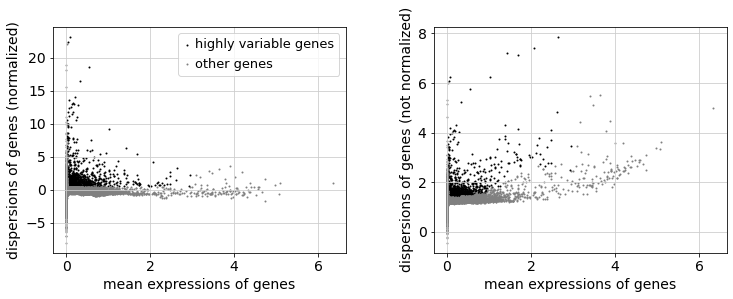

In [9]:
sc.pl.highly_variable_genes(adata_scrub)

In [6]:
sc.pp.scale(adata_scrub, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [7]:
sc.tl.pca(adata_scrub, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:26)


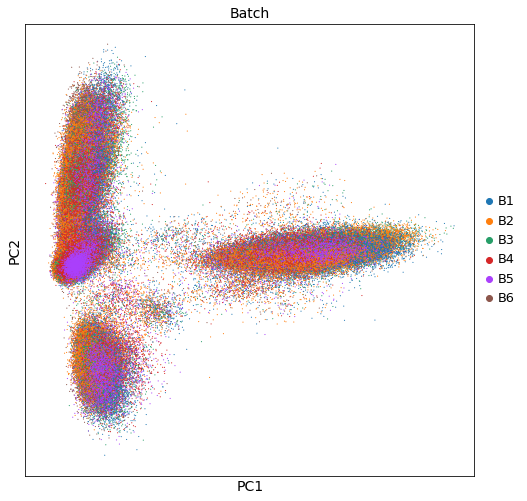

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sc.pl.pca(adata_scrub, color='Batch', ax=ax, size=5)

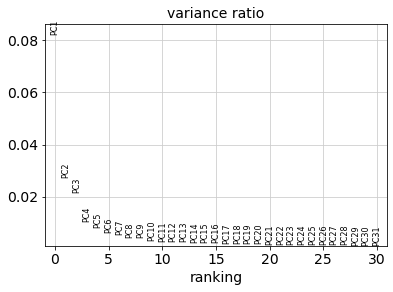

In [9]:
sc.pl.pca_variance_ratio(adata_scrub)

In [10]:
sce.pp.bbknn(adata_scrub, batch_key="Batch")

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:01:11)


In [11]:
sce.pp.harmony_integrate(adata_scrub, 'Batch')

2022-03-07 23:31:42,499 - harmonypy - INFO - Iteration 1 of 10
2022-03-07 23:35:03,497 - harmonypy - INFO - Iteration 2 of 10
2022-03-07 23:38:20,595 - harmonypy - INFO - Iteration 3 of 10
2022-03-07 23:41:38,138 - harmonypy - INFO - Converged after 3 iterations


In [13]:
sc.tl.leiden(adata_scrub)

running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:05:37)


In [16]:
harmony_df = pd.DataFrame(adata_scrub.obsm["X_pca_harmony"], columns=[f"hPC{_+1}" for _ in range(50)], index=adata_scrub.obs.index).merge(adata_scrub.obs, on='index')
pca_df = pd.DataFrame(adata_scrub.obsm["X_pca"], columns=[f"PC{_+1}" for _ in range(50)], index=adata_scrub.obs.index).merge(adata_scrub.obs, on='index')

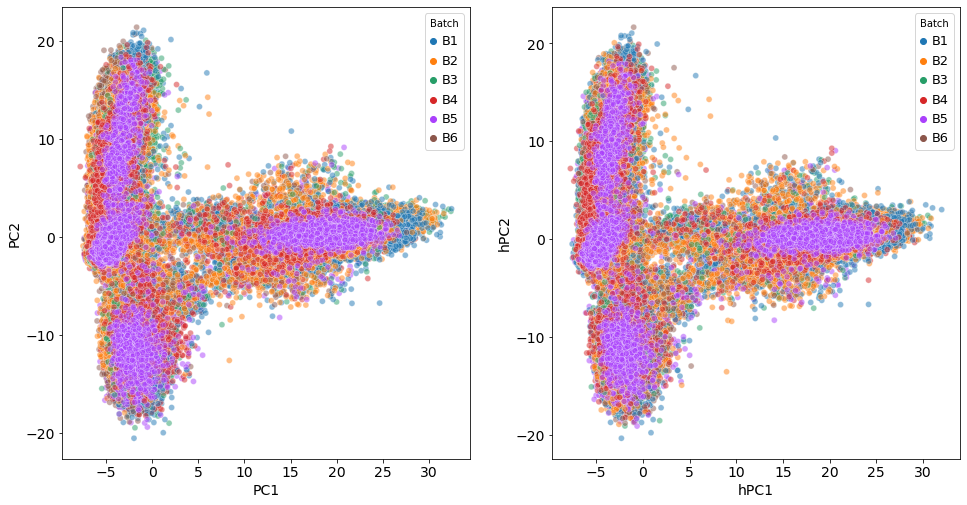

In [17]:
fig, axs = plt.subplots(1,2, figsize=(16,8))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Batch", alpha=0.5, ax=axs[0], sizes=(0.5, 0.5))
sns.scatterplot(data=harmony_df, x="hPC1", y="hPC2", hue="Batch", alpha=0.5, ax=axs[1], sizes=(0.5, 0.5))
axs[0].grid(False)
axs[1].grid(False)

In [19]:
sc.settings.set_figure_params(dpi=100, facecolor="white", fontsize=9)

/home/mileschristiansmith_gmail_com/miniconda3/envs/jupyter/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/mileschristiansmith_gmail_com/miniconda3/envs/jupyter/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


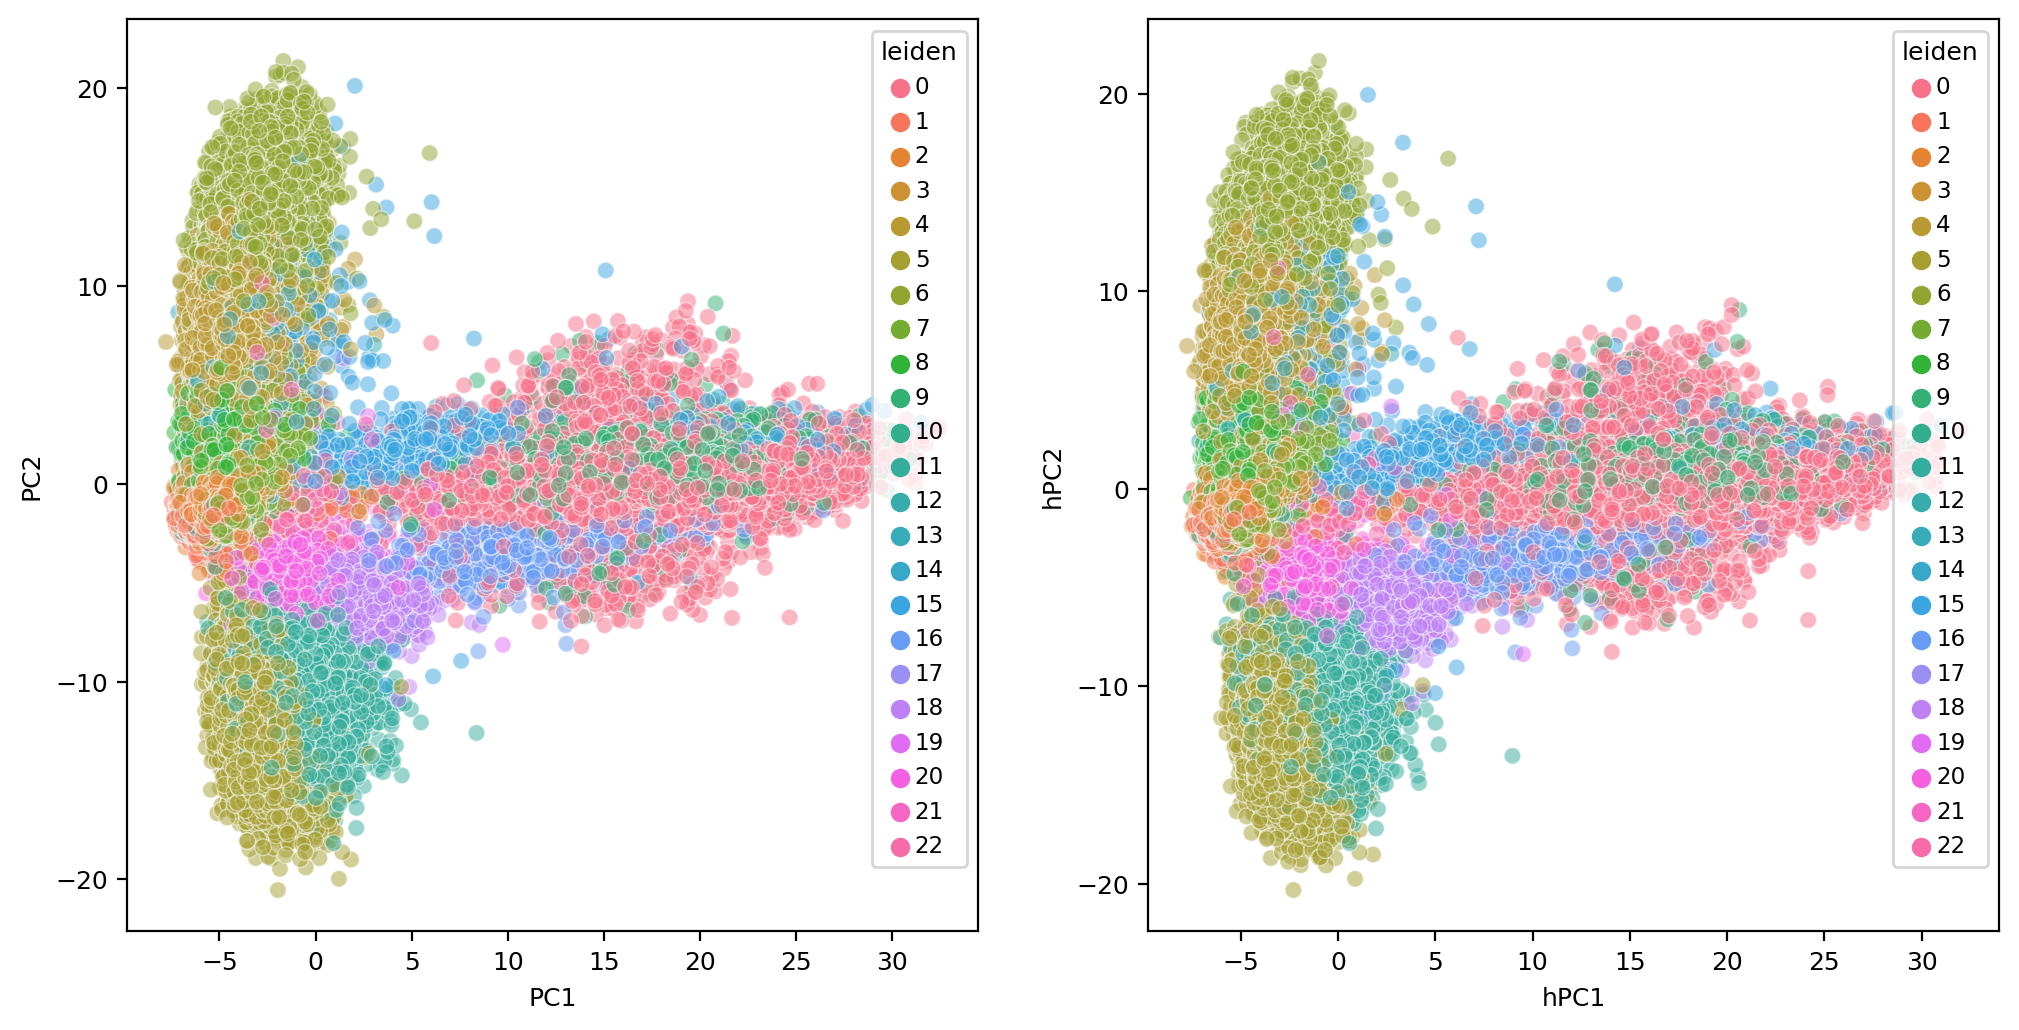

In [20]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
rcParams['axes.labelsize'] = 6
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="leiden", alpha=0.5, ax=axs[0], sizes=(0.5, 0.5))
sns.scatterplot(data=harmony_df, x="hPC1", y="hPC2", hue="leiden", alpha=0.5, ax=axs[1], sizes=(0.5, 0.5))
axs[0].grid(False)
axs[1].grid(False)

In [21]:
adata_scrub.write(filename=project_dir / "gse135779_scrubed_processed.h5ad")

In [22]:
# adata_scrub = sc.read(filename=project_dir / "gse135779_scrubed_processed.h5ad")

In [23]:
sc.tl.paga(adata_scrub, groups="leiden")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:16)


--> added 'pos', the PAGA positions (adata.uns['paga'])


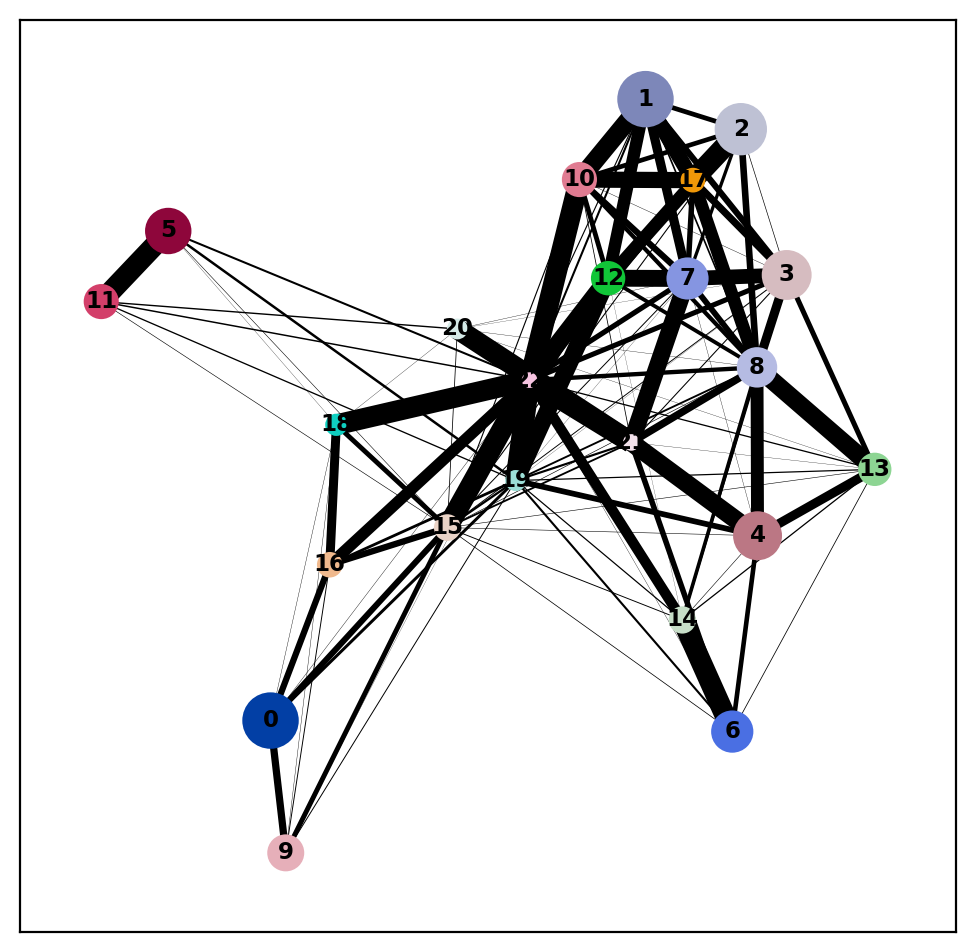

In [24]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sc.pl.paga(adata_scrub, ax=ax)

In [25]:
sc.tl.umap(adata_scrub, init_pos="paga")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:04:42)


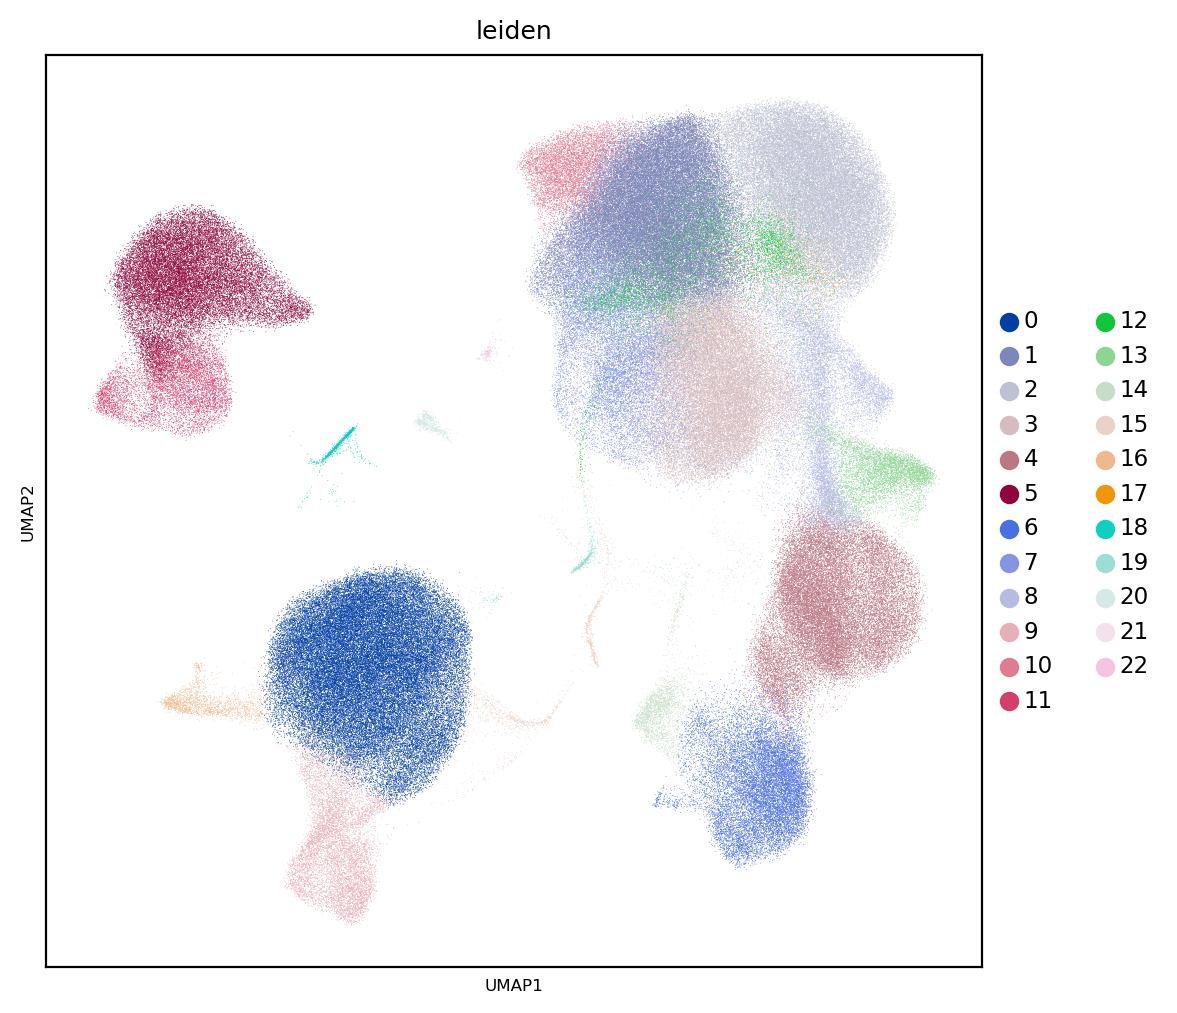

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sc.pl.umap(adata_scrub, color="leiden", ax=ax)

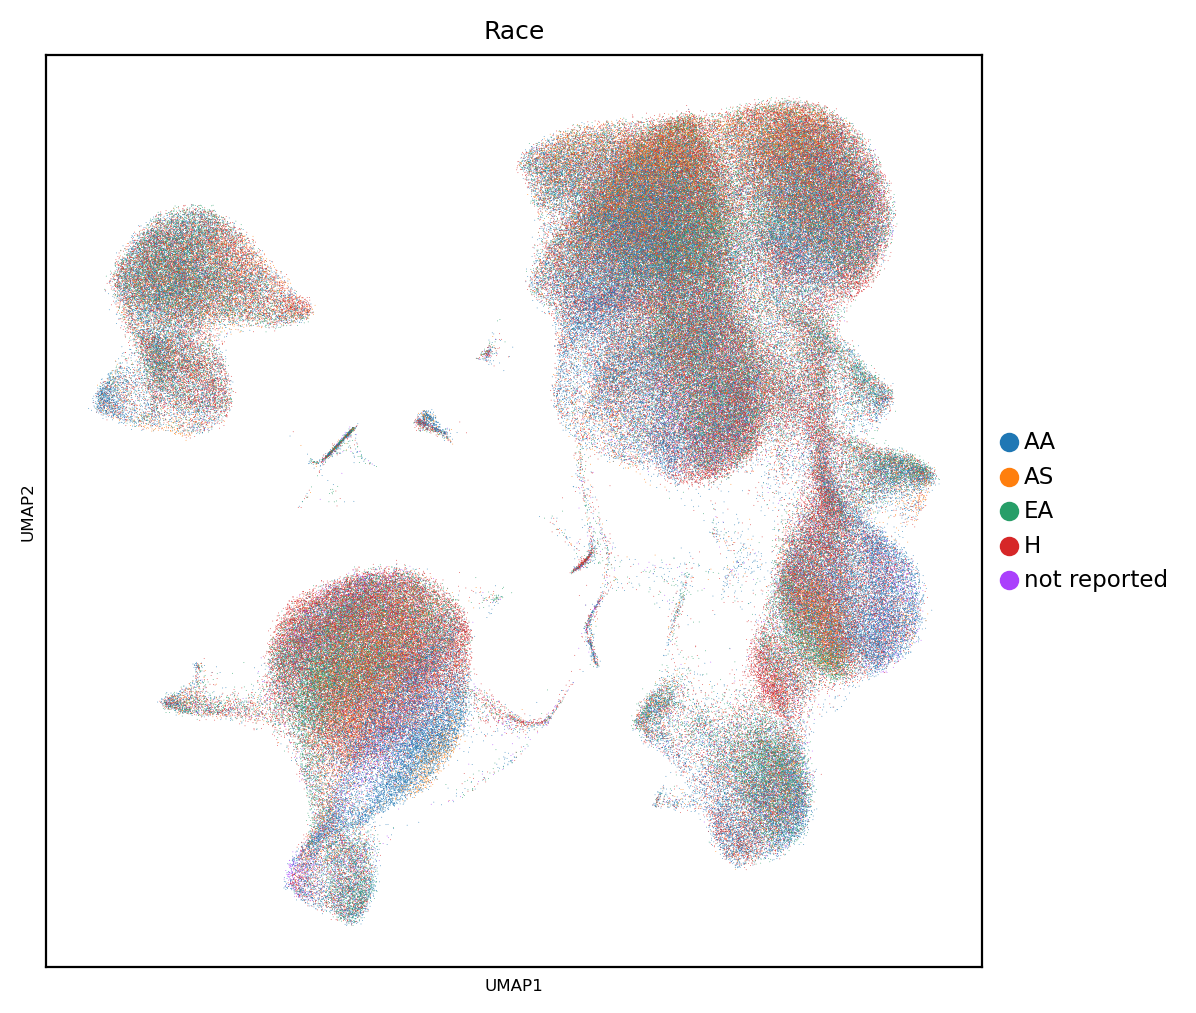

In [27]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sc.pl.umap(adata_scrub, color="Race", ax=ax)

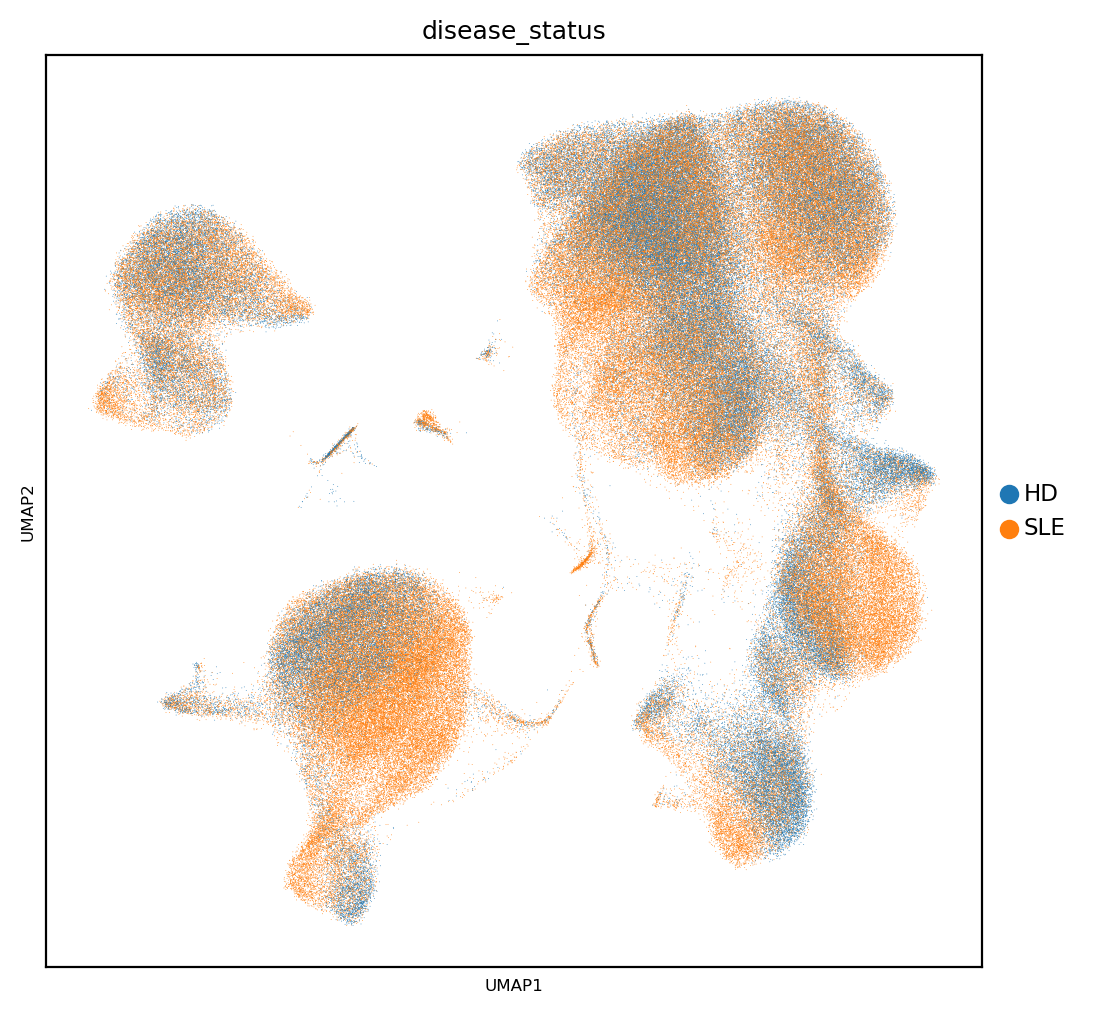

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sc.pl.umap(adata_scrub, color="disease_status", ax=ax)

In [29]:
adata_scrub.write(filename=project_dir / "gse135779_scrubed_processed.h5ad")